In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install --user numpy==1.21.6
# !pip install gensim==3.6.0
# !pip install --user spacy==3.4.4
# !python -m spacy download en_core_web_sm
# %pip install --user pyLDAvis
# !pip install --upgrade --user jinja2
# !pip install spacy_fastlang

In [5]:
%%capture
!pip install contextualized_topic_models
!pip install rbo

<!-- !wget -P {location of where you’d like the files to go} {first file to retrieve} {second file to retrieve} {nth file to retrieve} -->

In [ ]:
!wget -P /content/gdrive/MyDrive/projects/topic_modeling/data http://data.insideairbnb.com/united-states/dc/washington-dc/2022-12-20/data/reviews.csv.gz

--2023-02-11 08:10:25--  http://data.insideairbnb.com/united-states/dc/washington-dc/2022-12-20/data/reviews.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.36.213, 52.216.107.123, 54.231.136.109, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.36.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35080323 (33M) [application/x-gzip]
Saving to: ‘/content/gdrive/MyDrive/projects/topic_modeling/data/reviews.csv.gz’

reviews.csv.gz      100%[===================>]  33.46M  44.5MB/s    in 0.8s    

2023-02-11 08:10:26 (44.5 MB/s) - ‘/content/gdrive/MyDrive/projects/topic_modeling/data/reviews.csv.gz’ saved [35080323/35080323]



In [4]:
%%capture
import numpy as np
import pandas as pd
import re, nltk, gensim

import spacy
import spacy_fastlang
import en_core_web_sm

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

nlp = en_core_web_sm.load()
nltk.download('averaged_perceptron_tagger')
pd.set_option('display.max_colwidth', None)
nltk.download('stopwords')
spacy_nlp = spacy.load("en_core_web_sm")

**Load Data**

In [6]:
# Read in data
df = pd.read_csv('/content/gdrive/MyDrive/projects/topic_modeling/data/reviews.csv.gz', nrows=10000, compression='gzip')
# Take a look at the data
df.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3686,131293,2010-11-01,257234,Callie,"Staying with Levita and her wonderful family was an amazing experience. They were so welcoming to me and her home was great. I cannot express enough how nice my experience was. Not only is Levita's home very close to the metro, extremely comfortable, but her vegan cooking was incredible as well. Anyone would be lucky to stay with such a friendly, welcoming family."
1,3686,150766,2010-12-08,255888,Patrick,"Vita is a very welcoming, helpful and friendly host and a great cook. Her house is located in an interesting, not to say fascinating, area of Washington DC. Transport connections are close by and very frequent, the house (and the room where I stayed) are furnished in a very elegant style and I was always happy to come home in the evening to the friendly atmosphere of the household of Vita and her two daughters."
2,3686,177749,2011-02-02,366688,Benjamin,"This was my first time using ""airbnb"" and it made me wonder why I ever stayed in hotels in the past!! Vita was the most incredible host. Her home was warm and inviting, full of beautiful artwork and artistic people. The bedroom was immaculately clean and comfortable. It felt like a vacation...I even started my morning with a hot, leisurely bath! Vita is a wonderful chef, and runs an awesome food blog where she diary's her generous out-pouring of love and soul through food. I could write a whole blog myself on the wonderful experience I was treated to during my stay. But Vita is a great storyteller, so I'll leave the details to her....Check out her blog and learn something about healthy and delicious food in the meantime. http://vitasveganventures.wordpress.com/"
3,3686,197451,2011-03-12,213492,T.J.,"First, Vita saved my work week by providing me with very very very last minute acomodations. Vita's home was an absolute urban oasis! I was absolutely comfortable with the private accomodations. I regret not being able to spend more time with Vita and her family. I had a wonderful stay and look forward to being a guest in the future."
4,3686,213212,2011-03-30,428455,Pete,"Great host! Very welcoming and organised. I stayed for three nights while sightseeing in D.C. - the location is very convenient and Vita provided maps and guides. The room is lovely, the shower is hot and Vita shared her tasty vegan cooking! Would happily stay again."


In [7]:
df2=df.dropna(subset=['comments'])
df2.comments.head(3)

0                                                                                                                                                                                                                                                                                                                                                                                                                          Staying with Levita and her wonderful family was an amazing experience. They were so welcoming to me and her home was great. I cannot express enough how nice my experience was. Not only is Levita's home very close to the metro, extremely comfortable, but her vegan cooking was incredible as well. Anyone would be lucky to stay with such a friendly, welcoming family.
1                                                                                                                                                                                                                             

In [8]:
spacy_nlp.add_pipe("language_detector")
df2["lang"] = df2["comments"].apply(lambda x: spacy_nlp(x)._.language)
df_en = df2[df2["lang"] == "en"]

In [9]:
df_en

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang
0,3686,131293,2010-11-01,257234,Callie,"Staying with Levita and her wonderful family was an amazing experience. They were so welcoming to me and her home was great. I cannot express enough how nice my experience was. Not only is Levita's home very close to the metro, extremely comfortable, but her vegan cooking was incredible as well. Anyone would be lucky to stay with such a friendly, welcoming family.",en
1,3686,150766,2010-12-08,255888,Patrick,"Vita is a very welcoming, helpful and friendly host and a great cook. Her house is located in an interesting, not to say fascinating, area of Washington DC. Transport connections are close by and very frequent, the house (and the room where I stayed) are furnished in a very elegant style and I was always happy to come home in the evening to the friendly atmosphere of the household of Vita and her two daughters.",en
2,3686,177749,2011-02-02,366688,Benjamin,"This was my first time using ""airbnb"" and it made me wonder why I ever stayed in hotels in the past!! Vita was the most incredible host. Her home was warm and inviting, full of beautiful artwork and artistic people. The bedroom was immaculately clean and comfortable. It felt like a vacation...I even started my morning with a hot, leisurely bath! Vita is a wonderful chef, and runs an awesome food blog where she diary's her generous out-pouring of love and soul through food. I could write a whole blog myself on the wonderful experience I was treated to during my stay. But Vita is a great storyteller, so I'll leave the details to her....Check out her blog and learn something about healthy and delicious food in the meantime. http://vitasveganventures.wordpress.com/",en
3,3686,197451,2011-03-12,213492,T.J.,"First, Vita saved my work week by providing me with very very very last minute acomodations. Vita's home was an absolute urban oasis! I was absolutely comfortable with the private accomodations. I regret not being able to spend more time with Vita and her family. I had a wonderful stay and look forward to being a guest in the future.",en
4,3686,213212,2011-03-30,428455,Pete,"Great host! Very welcoming and organised. I stayed for three nights while sightseeing in D.C. - the location is very convenient and Vita provided maps and guides. The room is lovely, the shower is hot and Vita shared her tasty vegan cooking! Would happily stay again.",en
...,...,...,...,...,...,...,...
9995,3861766,535486711,2019-09-24,41388350,Jan,A really pretty apartment in a nice neighborhood. Good restaurants are an easy walk away. Marcy is very welcoming and gives you great tips about places to go and eat.,en
9996,3861766,540029007,2019-10-02,8728669,Cheryl,"Marcy is the consummate hostess - thoughtful, detailed, accessible, great communication. We loved the place - decor is comfortable, kitchen has what you need. We walk a lot, so location was excellent, 6-7 blocks from Dupont Circle train and we could go anywhere. Highly recommended.",en
9997,3861766,544609251,2019-10-10,46716178,Mary,"Marcy's place was perfect for me. The local was great, with tons of restaurants and supermarkets nearby. I was in town for work and every night looked forward to coming back to her place. Marcy was easy to get in touch with and provided good instructions to help me maximize my stay.",en
9998,3861766,548052323,2019-10-16,265166196,Maureen,Special place in the heart of DC. Apartment has everything you would need and you can walk to all the sites of DC. Marcy is a great Host and I will come back again.,en


## Cleaning the comments section in data

In [19]:
%%capture

from html import escape,unescape
pattern = r'[0-9]'

def preprocess_doc(doc):
  #Remove html tags
  gfg = escape(doc)
  text = unescape(gfg).replace("<br/>","").replace("\r","")
  text = re.sub(r'http\S+', '', text)

  text = re.sub(r"[-()\"#/@;:<>{}\-=~|.?,!]", "", text)
  # Match all digits in the string and replace them with an empty string
  text = re.sub(pattern, ' ', text)
  return text

# Take only Nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #Keep only common nouns
    filtered = [word[0] for word in pos_comment if (word[1] in ['NN'] and word[1] != 'NNP' and word[1] != 'NNPS')]
    # to filter both noun and verbs
    # filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ'] and word[1] != 'NNP' and word[1] != 'NNPS' ]
    return " ".join(filtered)

In [20]:
df_en["comments"].head(2).apply(lambda x: noun_only(preprocess_doc(x).split()))

0                        family experience home experience home metro cooking family
1    helpful host cook house area house room style home evening atmosphere household
Name: comments, dtype: object

In [21]:
# remove proper noun specially related to owner names. May be add those in stopwords list and remove from the text
# take 3+ chars

# NLTK English stopwords
stopwords = nltk.corpus.stopwords.words('english')
# Print out the NLTK default stopwords
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

There are 179 default stopwords. They are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'no

In [26]:
%%capture

custom_vec = CountVectorizer(
                             # analyzer='word',       
                             min_df=5, # minimum reqd occurences of a word 
                             stop_words=stopwords, # remove stop words
                             lowercase=True, # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                             # max_features=50000, # max number of uniq words,
                             ngram_range=(1, 2)
                             )
corpora = df_en["comments"].apply(lambda x: noun_only(preprocess_doc(x).split()))
cwm = custom_vec.fit_transform(corpora)

In [27]:
corpora

0                                                                                                   family experience home experience home metro cooking family
1                                                                               helpful host cook house area house room style home evening atmosphere household
2       time host home artwork bedroom vacationI morning chef food blog outpouring love soul food blog experience stay storyteller blog something food meantime
3                                                                                                     work week minute home oasis time family stay guest future
4                                                                                                                     host welcoming location room shower vegan
                                                                                 ...                                                                           
9995                                    

# Finding Best parameters for LDA

Optimizing the number of topics
LDA requires that we specify the number of topics that exists in a corpus of text. There are several common measures that can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability. This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimize this measure.

Ref: https://nicharuc.github.io/topic_modeling/

In [28]:
corpus = [ words.split() for words in corpora.values]

#### eval_every (int, optional) – Log perplexity is estimated every that many updates. Setting this to one slows down training by ~2x.

#### Since eval_every calculates perplexity metric, we can set it to None to save time, as we will use a different metric called Cv.

In [31]:
def get_all_topics(tm, num_topics, lambd = 0.6, topk=10):
  #lambda : Relevancy metric
  all_topics = []
  for i in range(1,num_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
      topic = tm.topic_info[tm.topic_info.Category == 'Topic'+str(i)].copy()
      topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
      all_topics.append(list(topic.sort_values(by='relevance', ascending=False).Term[:topk].values))
  return all_topics

In [33]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO

def get_top_k_topic_terms(lda_model, num_topics, topk=5):
    topic_terms = []
    for i in range(num_topics):
        topic_words_list = []
        # Only return 2-tuples `(word_id, probability)` for the topn most probable words (ignore the rest).
        for word_tuple in lda_model.get_topic_terms(i, topk):
            topic_words_list.append(dictionary[word_tuple[0]])
        topic_terms.append(topic_words_list)
    return topic_terms


def get_eval_metrics(lda_model, num_topics, num_terms, lambd= 0.6):
  topic_data_num_topics =  gensimvis.prepare(lda_model, doc_term_matrix, dictionary, mds = 'pcoa')

  all_topics = get_all_topics(topic_data_num_topics, num_topics, lambd, topk=num_terms)

  coh = CoherenceNPMI(get_top_k_topic_terms(lda_model, num_topics, topk=num_terms), corpus)
  print("coherence score CTM:", coh.score())

  irbo_lda = InvertedRBO(get_top_k_topic_terms(lda_model, num_topics, topk=num_terms))
  print(f"diversity score LDA on top {num_terms} terms:  {irbo_lda.score()}")

  irbo_ctm = InvertedRBO(all_topics)
  print(f"diversity score post lambda adjustment (lowering from 1 to {lambd}): {irbo_ctm.score()}")


Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22


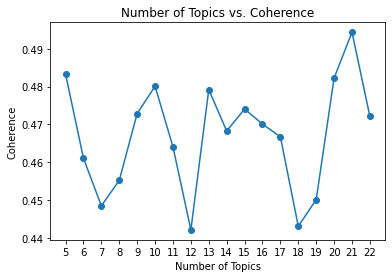

In [29]:
dictionary = gensim.corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

coherence = []
for k in range(5,23):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=30,\
                   iterations=300, chunksize = 10000, eval_every = None)  # chunksize is the number of documents to be used in each training chunk.
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=corpus,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Calculate Coherence score and Diversity (Inverted RBO score)

In [61]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_13_topics = Lda(doc_term_matrix, num_topics=13, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

First trying on taking 13 topic count

In [62]:
 #Without tuning lambda
 get_eval_metrics(ldamodel_13_topics, num_topics=13, num_terms=10)

coherence score CTM: 0.011028456847425993
diversity score LDA on top 10 terms:  0.7691467005428572
diversity score post lambda adjustment (lowering from 1 to 0.6): 0.9220983157679488


In [32]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Tuning Relevancy score lambda, to priortize terms more exclusive to topic by lowering lambda from default 1

In [63]:
topic_data_13_topics =  gensimvis.prepare(ldamodel_13_topics, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data_13_topics)

Now trying on 21 topics

In [38]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_21_topics = Lda(doc_term_matrix, num_topics=21, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [39]:
 #Without tuning lambda
 get_eval_metrics(ldamodel_21_topics, num_topics=21, num_terms=10)

coherence score CTM: 0.004394144148394224
diversity score LDA on top 10 terms:  0.8089263155377551
diversity score post lambda adjustment (lowering from 1 to 0.6): 0.9682946097973809


Now trying on 10 topics

In [41]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_10_topics = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [42]:
 #Without tuning lambda
 get_eval_metrics(ldamodel_10_topics, num_topics=10, num_terms=10)

coherence score CTM: 0.01034931626848948
diversity score LDA on top 10 terms:  0.7682857848525397
diversity score post lambda adjustment (lowering from 1 to 0.6): 0.9164382128077778


In [43]:
topic_data_10_topics =  gensimvis.prepare(ldamodel_10_topics, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data_10_topics)

In [46]:
 #Tuning lambda to from above graph
 get_eval_metrics(ldamodel_10_topics, num_topics=10, num_terms=10, lambd=0.6)

coherence score CTM: 0.01034931626848948
diversity score LDA on top 10 terms:  0.7682857848525397
diversity score post lambda adjustment (lowering from 1 to 0.6): 0.9164382128077778


Topic count 13 gives best coherence score

In [73]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.5 # Adjust this accordingly based on tuning above
for i in range(1,13): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data_13_topics.topic_info[topic_data_13_topics.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values


pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,apartment,coffee,kitchen,water,tea,hotel,gallery,area,shower,microwave
Topic 2,way,stay,place,area,cozy,convenient,walk,line,bus,stop
Topic 3,home,walk,apartment,coffee,family,grocery,location,store,husband,stay
Topic 4,stay,everything,apartment,information,host,location,appartment,neighbourhood,book,perfect
Topic 5,place,host,room,recommend,kind,trip,anyone,experience,welcoming,time
Topic 6,room,bedroom,bathroom,floor,issue,bit,living,noise,night,bed
Topic 7,house,home,Everything,room,station,ride,cat,bike,host,metro
Topic 8,center,convention,bed,dryer,washer,sofa,place,mattress,air,building
Topic 9,parking,spot,pass,car,permit,street,place,drive,location,area
Topic 10,arrival,reservation,space,posting,basement,house,owner,level,smell,property


Observation

In [ ]:
# Topic 1 -> Apartment facilities and services
# Topic 2 -> Relax and coziness
# Topic 3	-> Family friendly
# Topic 4 -> Location and neighborhood facilities
# Topic 5 -> About experience with Host
# Topic 6 -> About room experience
# Topic 7 -> everything about home experience
# Topic 8 -> Convention center, event friendly
# Topic 9 -> Parking space
# Topic 10 -> Arrival experience
# Topic 11 -> Public transport facility
# Topic 12 -> Budget friendliness